In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys

current_path = '/content/drive/My Drive/Colab Notebooks/300/'

os.chdir(current_path)

Mounted at /content/drive


### requirements

In [3]:
!pip install mpl_finance

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from funcs_indicator import *
# import matplotlib.pyplot as plt

# import mpl_finance as mf
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### load data

In [4]:
os.chdir(current_path)


interval = '30m'
interval = '5m'
interval = '1m'

date_path = './candlestick_concated/%s/2021-04-27/' % interval
date_path = './candlestick_concated/%s/2021-05-17/' % interval
# date_path = './candlestick_concated/%s/2021-06-14/' % interval
date_path = './candlestick_concated/%s/eth_set/' % interval
file_list = os.listdir(date_path)

print((file_list))

['2021-05-17 ETHUSDT.xlsx', '2021-04-18 ETHUSDT.xlsx', '2021-03-19 ETHUSDT.xlsx', '2021-02-17 ETHUSDT.xlsx', '2021-01-18 ETHUSDT.xlsx', '2020-12-19 ETHUSDT.xlsx', '2020-11-19 ETHUSDT.xlsx', '2020-10-20 ETHUSDT.xlsx', '2020-09-20 ETHUSDT.xlsx', '2020-08-21 ETHUSDT.xlsx', '2020-07-22 ETHUSDT.xlsx', '2020-06-22 ETHUSDT.xlsx', '2020-05-23 ETHUSDT.xlsx', '2020-04-23 ETHUSDT.xlsx']


#### window settings

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


start_stamp = 0
# start_stamp = datetime.timestamp(pd.to_datetime('2021-02-12'))
print("start_stamp :", start_stamp)
# break

np.random.shuffle(file_list)
candis = file_list

prev_x = None
total_x = None

seed = 1
random_state = 201
np.random.seed(seed)

fee = 0.0006
lvrg = 1

window_size = 30
input_size = 15
label_size = 15

target = "pr"

start_stamp : 0


#### make datasets

In [ ]:
data_x, data_labels = [], []
data_x_labels = []

# close_x, label_close_x = [], []
# data_index = []

for i in tqdm(range(len(candis))):

  keys = [candis[i]]

  # if 'neo'.upper() not in candis[i]:
    # continue
  
  # if 'btc'.upper() not in candis[i]:
  #   continue

  if 'eth'.upper() not in candis[i]:
    continue

  for key in keys:  
    
    ohlcv = pd.read_excel(date_path + key, index_col=0)
    print('len(ohlcv) :', len(ohlcv))
    df = ohlcv

    # df['pr'] = df['close'].pct_change()

    #   진입 구간과 이탈 구간에서 발생하는 pr 만들기    #

    # fee = 0.0006
    df['pr'] = df['close'].shift(-(label_size - 1)) / df['close']

    # print(df['close'].head(20))
    # print(df['close'].shift(-14).head(20))
    # break

    # sar = lucid_sar(ohlcv)
    # ha_ohlc = heikinashi(ohlcv).iloc[:, :4]
    # ema1, ema2, ema3 = ema_ribbon(ohlcv)
    # senkou1, senkou2 = ichimoku(ohlcv)
    # cbo, ema_cbo = cct_bbo(ohlcv, 21, 13) 

    # _, _, bbw = bb_width(ohlcv, 20, 2) 

    df['fish60'] = fisher(ohlcv, 60)
    df['trix'] = trix_hist(ohlcv, 14, 1, 5) 
    # rsi_ = rsi(ohlcv)
    df['macd_hist'] = macd(ohlcv)

    # print(df.describe().transpose())
    # print(df.head())

    # print((np.isnan(df.values)))
    print("np.sum(np.isnan(df.values), axis=0) :", np.sum(np.isnan(df.values), axis=0))

    max_nan = np.max(np.sum(np.isnan(df.values), axis=0))
    # print(max_nan)

    df = df.iloc[max_nan:-max_nan]

    print("df.describe().transpose() :", df.describe().transpose())


    column_indices = {name: i for i, name in enumerate(df.columns)}
    num_features = df.shape[1]
    print("num_features :", num_features)
    print("column_indices :", column_indices)
    
    target_label_index = column_indices[target]

    from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler
    min_max = MinMaxScaler()
    std_scale = StandardScaler()

    def min_max_scale(npy_x):

      return (npy_x - np.min(npy_x)) / (np.max(npy_x) - np.min(npy_x))


    #       local scaling     #
    shift_size = window_size
    # shift_size = 1

    for i in range(input_size, len(df), shift_size):
        
        # temp_data = df.values[i - input_size:i]
        # temp_labels = df.values[i:i + label_size]

        # scaled_data = min_max_scale(df.values[i - input_size:i + label_size])
        # scaled_data = min_max.fit_transform(df.values[i - input_size:i + label_size])
        # temp_data = scaled_data[:input_size]
        # temp_labels = scaled_data[input_size:]

        #     ohlc    #
        temp_data = min_max_scale(df.values[i - input_size:i, :4])
        
        prev_data = df.values[i - input_size:i, :4]
        label_data = df.values[i: i + label_size, :4]
        temp_x_labels = (label_data - np.min(prev_data)) / (np.max(prev_data) - np.min(prev_data))

        temp_labels = df.values[i, target_label_index]

        # temp_data = std_scale.fit_transform(df.values[i - input_size:i])
        # # temp_labels = std_scale.transform(df.values[i:i + label_size])
        # temp_labels = df.values[i + shift - input_size:i + shift]

        # print(df.index[i - input_size:i][-1])
        # print(df.index[i:i + label_size][0])
        # print()

        if np.isnan(np.sum(temp_data)):
          continue

        data_x.append(temp_data)
        data_x_labels.append(temp_x_labels)
        data_labels.append(temp_labels)
        # close_x.append(df.values[i - input_size:i, [3]])
        # label_close_x.append(df.values[i:i + label_size, [3]])


data_x = np.array(data_x).astype(np.float32)
data_x_labels = np.array(data_x_labels).astype(np.float32)
data_labels = np.array(data_labels).astype(np.float32)

# print(len(df) - total_window_size)
print("data_x.shape :", data_x.shape)
print("data_x_labels.shape :", data_x_labels.shape)
print("data_labels.shape :", data_labels.shape)

print("data_x.dtype :", data_x.dtype)
print("data_labels.dtype :", data_labels.dtype)

len(ohlcv) : 43200
np.sum(np.isnan(df.values), axis=0) : [ 0  0  0  0  0 14 59  5 24]
df.describe().transpose() :              count          mean          std          min          25%          50%          75%           max
open       43082.0  1.520997e+03   217.902772  1044.510000  1327.062500  1447.060000  1743.265000   1876.830000
high       43082.0  1.522857e+03   217.826375  1051.750000  1328.907500  1449.985000  1745.237500   1878.880000
low        43082.0  1.519180e+03   217.970957  1041.130000  1325.430000  1444.570000  1741.477500   1875.100000
close      43082.0  1.521010e+03   217.903680  1044.640000  1327.090000  1446.995000  1743.252500   1876.830000
volume     43082.0  2.654204e+03  3033.647796    82.805000  1023.519750  1740.162000  3114.921750  70333.874000
pr         43082.0  1.000147e+00     0.006529     0.944119     0.996873     1.000090     1.003440      1.060664
fish60     43082.0  2.253192e-01     1.924299    -7.576834    -1.148836     0.220259     1.559112     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


len(ohlcv) : 43200
np.sum(np.isnan(df.values), axis=0) : [ 0  0  0  0  0 14 59  5 24]
df.describe().transpose() :              count         mean          std          min          25%          50%          75%           max
open       43082.0  3078.433613   675.723195  1952.630000  2422.992500  2942.320000  3731.247500   4368.450000
high       43082.0  3082.319883   676.707541  1983.050000  2427.000000  2944.200000  3739.452500   4379.180000
low        43082.0  3074.613112   674.740822  1900.000000  2419.662500  2940.500000  3723.720000   4362.260000
close      43082.0  3078.460091   675.716484  1953.160000  2423.037500  2942.295000  3731.512500   4368.420000
volume     43082.0  2675.023511  2843.861372   108.680000  1061.920750  1808.772000  3219.244500  61736.971000
pr         43082.0     1.000149     0.007107     0.888315     0.996795     1.000187     1.003564      1.076890
fish60     43082.0     0.295771     2.020756    -7.569433    -1.077438     0.279023     1.714434      7.59093

#### save dataset

In [ ]:
pair_name = key.split(".")[0].split(" ")[1]
x_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))
x_label_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_label_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))
label_save_path = current_path + 'npy/' + 'inner_tick_cnn_label_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len(data_x))

np.save(x_save_path, data_x)
np.save(x_label_save_path, data_x_labels)
np.save(label_save_path, data_labels)


#### load dataset

In [6]:
key = "dates ETHUSDT.xlsx"
len_data_x = 20103

pair_name = key.split(".")[0].split(" ")[1]
x_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len_data_x)
x_label_save_path = current_path + 'npy/' + 'inner_tick_cnn_x_label_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len_data_x)
label_save_path = current_path + 'npy/' + 'inner_tick_cnn_label_%s_%s_%s_%s.npy' % (input_size, label_size, pair_name, len_data_x)

data_x = np.load(x_save_path)
data_x_labels = np.load(x_label_save_path)
data_labels = np.load(label_save_path)

print("data_x.shape :", data_x.shape)
print("data_x_labels.shape :", data_x_labels.shape)
print("data_labels.shape :", data_labels.shape)

data_x.shape : (20103, 15, 4)
data_x_labels.shape : (20103, 15, 4)
data_labels.shape : (20103,)


### embedding extractor

#### resnet

In [50]:
from tensorflow.keras.applications.resnet50 import ResNet50

model = ResNet50(weights='imagenet', include_top=False)
# model.summary()


94773248/94765736 [==============================] - 1s 0us/step


#### pretrained custom model

In [53]:
pair_name = "ETHUSDT"
window_size = 30
input_size = 15
label_size = 15
last_index = 10000

model_name = 'inner_tick_cnn_lscalemm_%s_%s_%s_%s_copy.h5' % (pair_name, input_size, label_size, last_index)
ckpt_path = current_path + 'ckpt/'

model = tf.keras.models.load_model(ckpt_path + model_name)
model = tf.keras.models.Sequential(model.layers[:-1])

In [ ]:
# for layer in model.layers:
#   print(layer.name)

### testbed

last_index : 10000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_x_labels.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

32/32 [==============================] - 0s 2ms/step
(1000, 64)


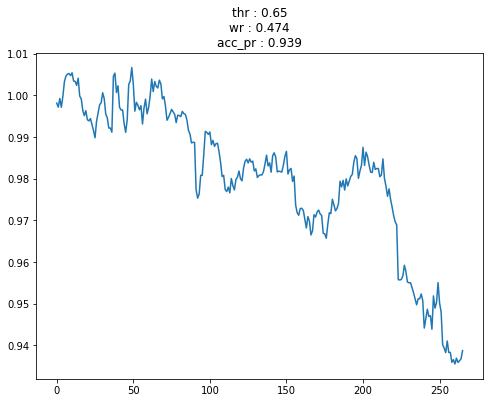

last_index : 11000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_x_labels.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

32/32 [==============================] - 0s 2ms/step
(1000, 64)


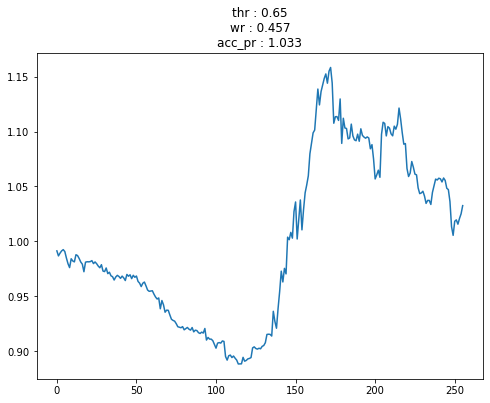

last_index : 12000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_x_labels.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

32/32 [==============================] - 0s 2ms/step
(1000, 64)


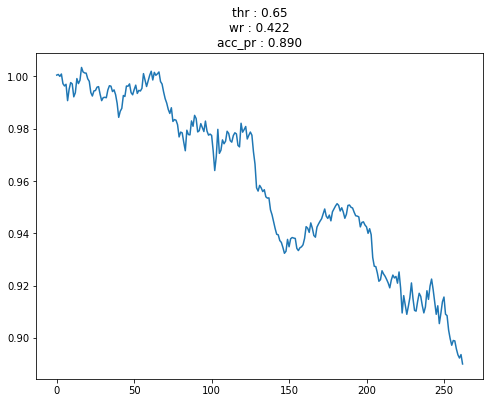

last_index : 13000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_x_labels.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

32/32 [==============================] - 0s 2ms/step
(1000, 64)


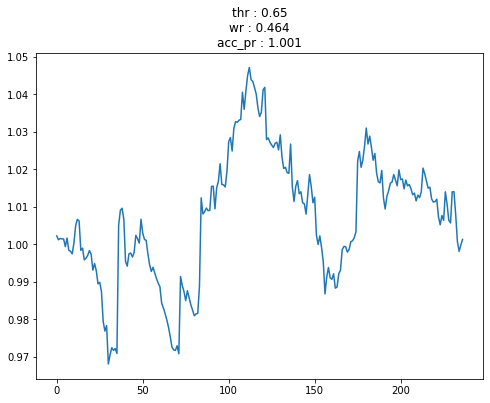

last_index : 14000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_x_labels.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

32/32 [==============================] - 0s 2ms/step
(1000, 64)


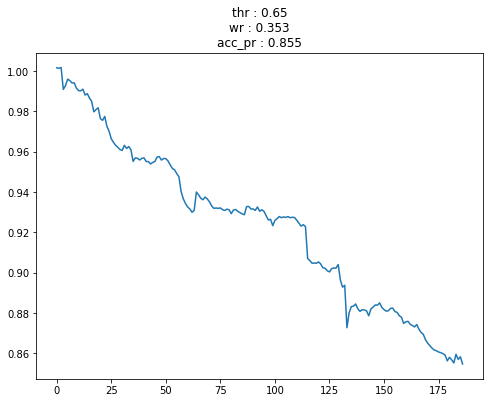

last_index : 15000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_x_labels.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

32/32 [==============================] - 0s 2ms/step
(1000, 64)


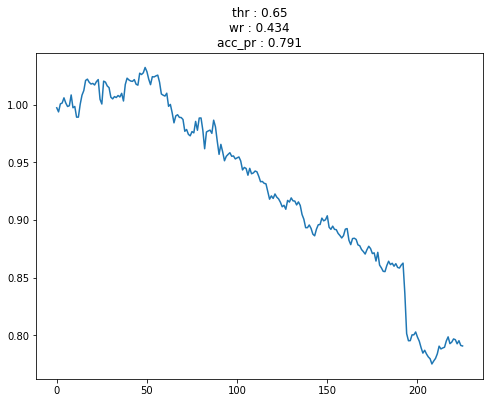

last_index : 16000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_x_labels.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

32/32 [==============================] - 0s 2ms/step
(1000, 64)


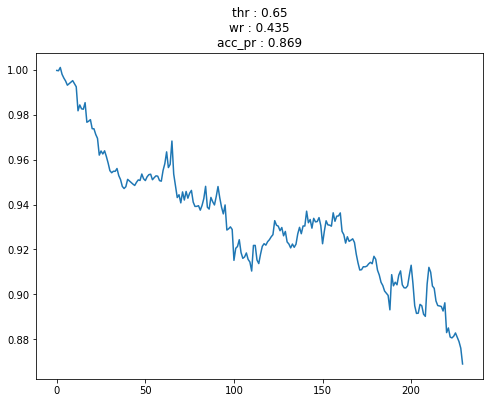

last_index : 17000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_x_labels.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

32/32 [==============================] - 0s 2ms/step
(1000, 64)


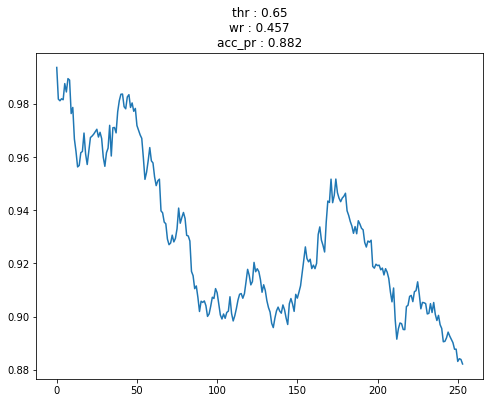

last_index : 18000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_x_labels.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

32/32 [==============================] - 0s 2ms/step
(1000, 64)


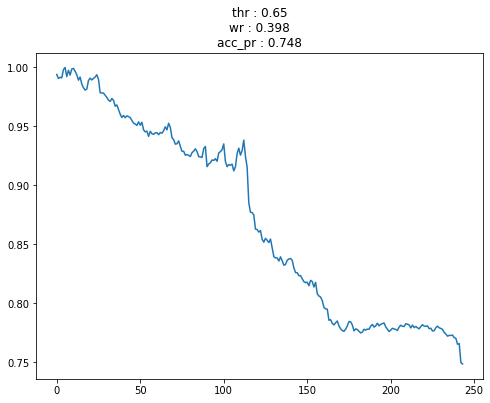

last_index : 19000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_x_labels.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

32/32 [==============================] - 0s 2ms/step
(1000, 64)


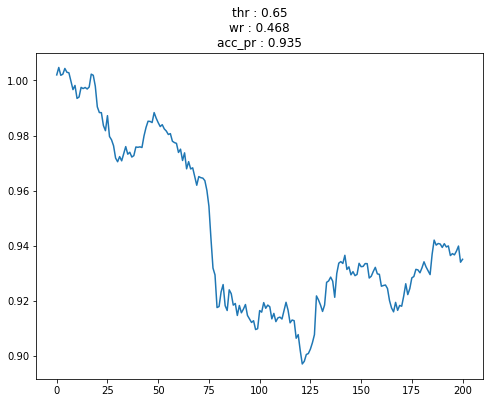

last_index : 20000
len(train_x) : 7000
len(val_x) : 2000
len(test_x) : 1000
train_x.shape : (7000, 15, 4, 1)
train_x_labels.shape : (7000, 15, 4, 1)
train_y.shape : (7000, 1)

32/32 [==============================] - 0s 2ms/step
(1000, 64)


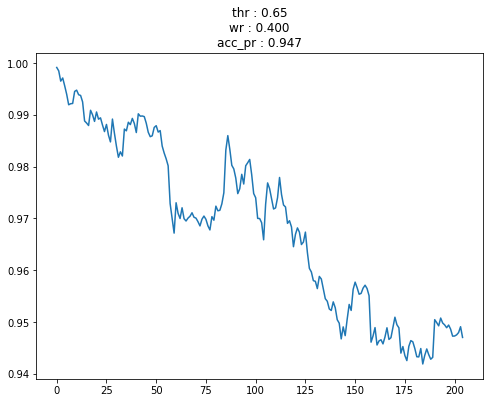

last_index : 21000


In [72]:
#         1. data slicing      #
tvt_size = 10000
shift_size = int(tvt_size * 0.1)
shift_i = 0

#         2. calc, iteration number     #
# data_len = len(data_x)


while 1:

  # if shift_i == 3:
  #   pass
  # else:
  #   shift_i += 1
  #   continue

  last_index = tvt_size + shift_size * shift_i
  print("last_index :", last_index)
  # print("last_index :", last_index)

  slice_x = data_x[shift_size * shift_i :last_index]
  slice_x_labels = data_x_labels[shift_size * shift_i :last_index]
  
  #   reshape to 3d   #
  slice_x = slice_x.reshape(-1, slice_x.shape[1], slice_x.shape[2], 1)
  # slice_x = slice_x.reshape(-1, slice_x.shape[1], slice_x.shape[2], 1) * np.ones(3, dtype=np.float32)[None, None, None, :]

  slice_x_labels = slice_x_labels.reshape(-1, slice_x_labels.shape[1], slice_x_labels.shape[2], 1)

  slice_labels = data_labels[shift_size * shift_i :last_index].reshape(-1, 1)

  if last_index > len(data_x):
    break

  else:
    shift_i += 1


  train_x = slice_x[:int(tvt_size * 0.7)]
  val_x = slice_x[int(tvt_size * 0.7):int(tvt_size * 0.9)]
  test_x = slice_x[int(tvt_size * 0.9):]

  print("len(train_x) :", len(train_x))
  print("len(val_x) :", len(val_x))
  print("len(test_x) :", len(test_x))

  train_x_labels = slice_x_labels[:int(tvt_size * 0.7)]
  val_x_labels = slice_x_labels[int(tvt_size * 0.7):int(tvt_size * 0.9)]
  test_x_labels = slice_x_labels[int(tvt_size * 0.9):]

  train_labels = slice_labels[:int(tvt_size * 0.7)]
  val_labels = slice_labels[int(tvt_size * 0.7):int(tvt_size * 0.9)]
  test_labels = slice_labels[int(tvt_size * 0.9):]

  pr_thresh = 1

  train_y = np.where(train_labels > pr_thresh, 1, 0)
  val_y = np.where(val_labels > pr_thresh, 1, 0)
  test_y = np.where(test_labels > pr_thresh, 1, 0)
  
  from tensorflow.keras import utils

  train_y_ohe = utils.to_categorical(train_y, 2)
  val_y_ohe = utils.to_categorical(val_y, 2)
  test_y_ohe = utils.to_categorical(test_y, 2)

  # train_y = train_labels[:, :, [target_label_index]]
  # val_y = val_labels[:, :, [target_label_index]]
  # test_y = test_labels[:, :, [target_label_index]]

  # print("train_labels.shape :", train_labels.shape)
  print("train_x.shape :", train_x.shape)
  print("train_x_labels.shape :", train_x_labels.shape)
  print("train_y.shape :", train_y.shape)
  print()

  
  test_result = model.predict(test_x, verbose=1)
  print(test_result.shape)


  lb_period = 500  # lb_period 내에서 threshold / k-sample 만큼 추출한 후 win_ratio 를 확인

  def distance_logic(f1, f2):
    return np.linalg.norm(f1-f2)


  threshold = 0.55
  sample_size = 3
  pr_thresh = 1.00
  lvrg = 1
  fee = 0.0006

  show_detail = False
  plotting = False
  pr_plot = True
  total_pr = []

  for i in (range(lb_period, len(test_result))):
    
    min_diff = np.inf
    sample_list = []
    nearest_pr = 1
    min_list = []
    
    for j in range(i - lb_period, i):

      #       if feature distance under the threshold, append to the sample     #
      diff = distance_logic(test_result[i], test_result[j])
      
      # if diff < min_diff:
      # if diff < min_diff and diff < threshold:
      if diff < threshold:

        min_diff = diff
        # print("min_diff updated to", min_diff)

      # if diff < threshold:
        nearest_pr = test_labels[j]

        #       마지막 인덱스의 diff 가 가장 작음   #
        min_list.append(nearest_pr)

        if plotting:
          fig = plt.figure(figsize=(10, 4))
          # ax = fig.add_subplot(211)
          ax = fig.add_subplot(111)

          #       concat with x_labels      #
          ind_temp_ohlc = np.vstack((test_x[i, :, :, 0], test_x_labels[i, :, :, 0]))
          # print("ind_temp_ohlcv.shape :", ind_temp_ohlc.shape)

          index = np.arange(len(ind_temp_ohlc))
          candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
          mf.candlestick_ohlc(ax, candle, width=0.5, colorup='r', colordown='b')

          # ax2 = fig.add_subplot(212)
          ind_temp_ohlc = np.vstack((test_x[j, :, :, 0], test_x_labels[j, :, :, 0]))

          print("ind_temp_ohlc.shape :", ind_temp_ohlc.shape)

          index = np.arange(len(ind_temp_ohlc))
          candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
          mf.candlestick_ohlc(ax, candle, width=0.5, colorup='m', colordown='c')

          plt.title("%s ~= %s" % (i, j))

          # plt.plot(ind_temp_ohlc)
          plt.axvline(input_size)

          plt.show()
          plt.close()

    #         check wr        #
    # if len(sample_list) > 0:
    #   sample_list = np.array(sample_list)
    #   wr = len(sample_list[sample_list > 1]) / len(sample_list[sample_list != 1])
      
      # print("win_ratio : %.3f" % wr) 
      # print("sample cnt : %s" % len(sample_list))

    # if nearest_pr > 1:
    if len(min_list) >= sample_size and np.cumprod(min_list[-sample_size:])[-1] > pr_thresh:
    # if len(min_list) >= sample_size and np.mean(min_list[-sample_size:]) > pr_thresh:

      if show_detail:
      #   print("win_ratio : %.3f" % wr) 
      #   print("sample cnt : %s" % len(sample_list))
        print("test_labels[i] :", test_labels[i])

      total_pr.append(test_labels[i]) 
      
    # print("last min_diff", min_diff)
    if len(total_pr) > 0 and show_detail:
      print("-------------------------------")
      print("acc pr : ", np.cumprod(total_pr)[-1])

  if len(total_pr) > 0 and pr_plot:
    
    np_total_pr = (np.array(total_pr) - 1 - fee) * lvrg + 1
    total_wr = len(np_total_pr[np_total_pr > 1]) / len(np_total_pr)
    plt.plot(np.cumprod(np_total_pr))
    plt.title("thr : %.2f\nwr : %.3f\nacc_pr : %.3f" % (threshold, total_wr, np.cumprod(np_total_pr)[-1]))
    plt.show()

  # break

### feature extraction

In [9]:
# avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
# output = keras.layers.Flatten()(base_model.output)
# model = keras.models.Model(inputs=base_model.input, outputs=output)

test_result = model.predict(test_x, verbose=1)
print(test_result.shape)

32/32 [==============================] - 14s 2ms/step
(1000, 64)


### check similar pattern

#### get nearest feature

In [16]:
import itertools
from tqdm.notebook import tqdm

def findDifference(f1, f2):
  return np.linalg.norm(f1-f2)

def findDifferences(feature_vectors, min_gap):
  similar: dict = {}
  keys = [k for k,v in feature_vectors.items()]
  min : dict = {}
  # for k in keys:
  #     min[k] = np.inf

  possible_combinations=list(itertools.combinations(keys, 2))

  min_prev_data = 500

  for i in tqdm(range(min_prev_data, len(keys) - 1)):

    min[i] = np.inf

    for j in range(i - min_prev_data, i):

      if abs(i - j) > min_gap:

        diff = findDifference(feature_vectors[i],feature_vectors[j])

        if diff < min[i]:
            min[i] = diff
            similar[i] = j
            # min[v] = diff
            # similar[v] = k

  # for i in tqdm(range(len(possible_combinations))):
  # # for i, (k,v) in range(len(possible_combinations)):
  #     k, v = possible_combinations[i]

  #     if abs(k - v) > min_gap:

  #       diff=findDifference(feature_vectors[k],feature_vectors[v])
  #       if diff < min[k]:
  #           min[k] = diff
  #           similar[k] = v
  #           min[v] = diff
  #           similar[v] = k

  return similar 



period = 1

feature_vectors: dict = {}
for index in tqdm(range(len(test_result))):
    feature_vectors[index] = test_result[index]

results=findDifferences(feature_vectors, period)

# for k,v in results.items():
#     # print(k +" is most similar to: "+ v)   
#     print("%s is most similar to: %s" % (k, v))   

    #print('Predicted:', decode_predictions(preds, top=3)[0])


In [17]:
# keys = [k for k,v in feature_vectors.items()]
# print(keys)
# # print(feature_vectors.items())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

#### check nearest one

In [ ]:
import mpl_finance as mf

for k, v in results.items():

  fig = plt.figure(figsize=(10, 4))
  # ax = fig.add_subplot(211)
  ax = fig.add_subplot(111)

  #       concat with x_labels      #
  ind_temp_ohlc = np.vstack((test_x[k, :, :, 0], test_x_labels[k, :, :, 0]))
  # print("ind_temp_ohlcv.shape :", ind_temp_ohlc.shape)

  index = np.arange(len(ind_temp_ohlc))
  candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
  mf.candlestick_ohlc(ax, candle, width=0.5, colorup='r', colordown='b')

  # ax2 = fig.add_subplot(212)
  ind_temp_ohlc = np.vstack((test_x[v, :, :, 0], test_x_labels[v, :, :, 0]))

  print("ind_temp_ohlc.shape :", ind_temp_ohlc.shape)

  index = np.arange(len(ind_temp_ohlc))
  candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
  mf.candlestick_ohlc(ax, candle, width=0.5, colorup='m', colordown='c')

  plt.title("%s ~= %s" % (k, v))

  # plt.plot(ind_temp_ohlc)
  plt.axvline(input_size)
  plt.show()

#### k-means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

feature_list = []

for i in range(len(test_result)):

  feature_list.append(test_result[i].flatten())

feature_list = np.array(feature_list)
print(feature_list.shape)


K = range(2, 10)
s_dist = []
sil = []
for k in tqdm(K):
  # if cen_data.shape[0] < k:
  #   break

  km = KMeans(n_clusters=k)
  km = km.fit(feature_list)

  labels = km.labels_
  # print('len(labels) :', len(labels))
  # print('labels[:10] :', labels[:10])
  sil.append(silhouette_score(feature_list, labels, metric='euclidean'))

  # inertia = km.inertia_
  # s_dist.append(inertia)

best_k = K[np.argmax(np.array(sil))]

plt.figure(figsize=(10, 5))
plt.plot(K, sil)
plt.axvline(best_k, linestyle='--')
# plt.plot(K, s_dist)
plt.show()


### pr opt by similar pattern

#### winratio by nearest one

In [33]:
from tqdm.notebook import tqdm
import mpl_finance as mf

lb_period = 500  # lb_period 내에서 threshold / k-sample 만큼 추출한 후 win_ratio 를 확인

def distance_logic(f1, f2):
  return np.linalg.norm(f1-f2)


threshold = 0.5

show_detail = False
plotting = False
pr_plot = False

total_ap = []
threshold_list = np.arange(0.3, 0.6, 0.01)
threshold_list = np.arange(0.6, 0.7, 0.01)

# threshold_list = [0.59]
# pr_plot = True

for threshold in tqdm(threshold_list):

  total_pr = []

  for i in (range(lb_period, len(test_result))):
    
    min_diff = np.inf
    sample_list = []
    nearest_pr = 1
    for j in range(i - lb_period, i):

      #       if feature distance under the threshold, append to the sample     #
      diff = distance_logic(test_result[i], test_result[j])
      
      # if diff < min_diff:
      if diff < min_diff and diff < threshold:
        min_diff = diff
        # print("min_diff updated to", min_diff)

      # if diff < threshold:
        nearest_pr = test_labels[j]

        if plotting:
          fig = plt.figure(figsize=(10, 4))
          # ax = fig.add_subplot(211)
          ax = fig.add_subplot(111)

          ind_temp_ohlc = x_test[i, :, :, 0]
          # print("ind_temp_ohlcv.shape :", ind_temp_ohlc.shape)

          index = np.arange(len(ind_temp_ohlc))
          candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
          mf.candlestick_ohlc(ax, candle, width=0.5, colorup='r', colordown='b')

          # ax2 = fig.add_subplot(212)
          ind_temp_ohlc = x_test[j, :, :, 0]
          print("ind_temp_ohlc.shape :", ind_temp_ohlc.shape)

          index = np.arange(len(ind_temp_ohlc))
          candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
          mf.candlestick_ohlc(ax, candle, width=0.5, colorup='m', colordown='c')

          plt.title("%s ~= %s" % (i, j))

          # plt.plot(ind_temp_ohlc)
          plt.show()
          plt.close()

    #         check wr        #
    # if len(sample_list) > 0:
    #   sample_list = np.array(sample_list)
    #   wr = len(sample_list[sample_list > 1]) / len(sample_list[sample_list != 1])
      
      # print("win_ratio : %.3f" % wr) 
      # print("sample cnt : %s" % len(sample_list))

    if nearest_pr > 1:

      if show_detail:
      #   print("win_ratio : %.3f" % wr) 
      #   print("sample cnt : %s" % len(sample_list))
        print("test_labels[i] :", test_labels[i])

      total_pr.append(test_labels[i]) 
      
    # print("last min_diff", min_diff)
    if len(total_pr) > 0 and show_detail:
      print("-------------------------------")
      print("acc pr : ", np.cumprod(total_pr)[-1])

  if len(total_pr) > 0 and pr_plot:
    np_total_pr = np.array(total_pr)
    total_wr = len(np_total_pr[np_total_pr > 1]) / len(np_total_pr)
    plt.plot(np.cumprod(np_total_pr))
    plt.title("thr : %.2f\nwr : %.3f\nacc_pr : %.3f" % (threshold, total_wr, np.cumprod(np_total_pr)[-1]))
    plt.show()

  total_ap.append(np.cumprod(total_pr)[-1])




#### find best threshold

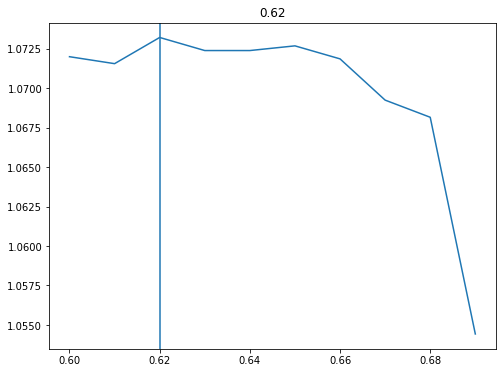

In [35]:
np_total_ap = np.array(total_ap)
argmax = np.argmax(np_total_ap)
threshold_list = np.arange(0.3, 0.6, 0.01)
threshold_list = np.arange(0.6, 0.7, 0.01)


plt.plot(threshold_list, np_total_ap)
plt.axvline(threshold_list[argmax])
plt.title(threshold_list[argmax])
plt.show()

#### winratio by threshold

In [ ]:
from tqdm.notebook import tqdm
import mpl_finance as mf

lb_period = 500  # lb_period 내에서 threshold / k-sample 만큼 추출한 후 win_ratio 를 확인

def distance_logic(f1, f2):
  return np.linalg.norm(f1-f2)


threshold = 0.3

total_pr = []
show_detail = False
plotting = False

for i in tqdm(range(lb_period, len(test_result))):
  
  min_diff = np.inf
  sample_list = []
  for j in range(i - lb_period, i):

    #       if feature distance under the threshold, append to the sample     #
    diff = distance_logic(test_result[i], test_result[j])
    # if diff < min_diff:
    #   min_diff = diff
      # print("min_diff updated to", min_diff)

    if diff < threshold:
      sample_list.append(pr_test[j])

      if plotting:
        fig = plt.figure(figsize=(10, 4))
        # ax = fig.add_subplot(211)
        ax = fig.add_subplot(111)

        ind_temp_ohlc = x_test[i, :, :, 0]
        # print("ind_temp_ohlcv.shape :", ind_temp_ohlc.shape)

        index = np.arange(len(ind_temp_ohlc))
        candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
        mf.candlestick_ohlc(ax, candle, width=0.5, colorup='r', colordown='b')

        # ax2 = fig.add_subplot(212)
        ind_temp_ohlc = x_test[j, :, :, 0]
        print("ind_temp_ohlc.shape :", ind_temp_ohlc.shape)

        index = np.arange(len(ind_temp_ohlc))
        candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
        mf.candlestick_ohlc(ax, candle, width=0.5, colorup='m', colordown='c')

        plt.title("%s ~= %s" % (i, j))

        # plt.plot(ind_temp_ohlc)
        plt.show()
        plt.close()

  #         check wr        #
  if len(sample_list) > 0:
    sample_list = np.array(sample_list)
    wr = len(sample_list[sample_list > 1]) / len(sample_list[sample_list != 1])
    
    # print("win_ratio : %.3f" % wr) 
    # print("sample cnt : %s" % len(sample_list))

    if wr > .7:

      if show_detail:
        print("win_ratio : %.3f" % wr) 
        print("sample cnt : %s" % len(sample_list))
        print("pr_test[i] :", pr_test[i])

      total_pr.append(pr_test[i])
    
  # print("last min_diff", min_diff)
  if len(total_pr) > 0 and show_detail:
    print("-------------------------------")
    print("acc pr : ", np.cumprod(total_pr)[-1])





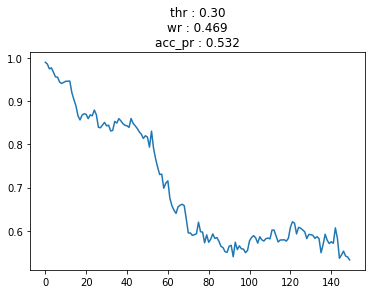

In [ ]:
total_pr = np.array(total_pr)
total_wr = len(total_pr[total_pr > 1]) / len(total_pr)
plt.plot(np.cumprod(total_pr))
plt.title("thr : %.2f\nwr : %.3f\nacc_pr : %.3f" % (threshold, wr, np.cumprod(total_pr)[-1]))
plt.show()

#### find best pattern & trade by it

In [ ]:
from tqdm.notebook import tqdm
import mpl_finance as mf

lb_period = 500  # lb_period 내에서 threshold / k-sample 만큼 추출한 후 win_ratio 를 확인

def distance_logic(f1, f2):
  return np.linalg.norm(f1-f2)


threshold = 0.3

total_pr = []
show_detail = True
plotting = False

most_acc_pr = 1
most_index_list = []

for i in tqdm(range(lb_period, len(test_result))):
  
  min_diff = np.inf
  sample_list = []
  for j in range(i - lb_period, i):

    #       if feature distance under the threshold, append to the sample     #
    diff = distance_logic(test_result[i], test_result[j])
    # if diff < min_diff:
    #   min_diff = diff
      # print("min_diff updated to", min_diff)

    if diff < threshold:
      sample_list.append(pr_test[j])

      if plotting:
        fig = plt.figure(figsize=(10, 4))
        # ax = fig.add_subplot(211)
        ax = fig.add_subplot(111)

        ind_temp_ohlc = x_test[i, :, :, 0]
        # print("ind_temp_ohlcv.shape :", ind_temp_ohlc.shape)

        index = np.arange(len(ind_temp_ohlc))
        candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
        mf.candlestick_ohlc(ax, candle, width=0.5, colorup='r', colordown='b')

        # ax2 = fig.add_subplot(212)
        ind_temp_ohlc = x_test[j, :, :, 0]
        print("ind_temp_ohlc.shape :", ind_temp_ohlc.shape)

        index = np.arange(len(ind_temp_ohlc))
        candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
        mf.candlestick_ohlc(ax, candle, width=0.5, colorup='m', colordown='c')

        plt.title("%s ~= %s" % (i, j))

        # plt.plot(ind_temp_ohlc)
        plt.show()
        plt.close()

  #         check wr        #
  if len(sample_list) > 0:
    sample_list = np.array(sample_list)
    wr = len(sample_list[sample_list > 1]) / len(sample_list[sample_list != 1])

    acc_pr = np.cumprod(sample_list)[-1]

    if acc_pr > 1:
    # if acc_pr > most_acc_pr:
      most_acc_pr = acc_pr
      most_index_list.append(i)
    
    # print("win_ratio : %.3f" % wr) 
    # print("sample cnt : %s" % len(sample_list))

    # if wr > .5:

    if show_detail:
      print("win_ratio : %.3f" % wr) 
      print("sample cnt : %s" % len(sample_list))
      print("acc_pr :", acc_pr)
      print("----------------------")

      # total_pr.append(pr_test[i])
    




Streaming output truncated to the last 5000 lines.
sample cnt : 33
acc_pr : 0.8729078
----------------------
win_ratio : 0.400
sample cnt : 25
acc_pr : 0.75526017
----------------------
win_ratio : 0.417
sample cnt : 12
acc_pr : 0.957374
----------------------
win_ratio : 0.250
sample cnt : 4
acc_pr : 0.93690974
----------------------
win_ratio : 0.250
sample cnt : 4
acc_pr : 0.931567
----------------------
win_ratio : 0.500
sample cnt : 6
acc_pr : 0.9935385
----------------------
win_ratio : 0.667
sample cnt : 3
acc_pr : 1.0112773
----------------------
win_ratio : 0.333
sample cnt : 3
acc_pr : 0.99940854
----------------------
win_ratio : 0.556
sample cnt : 9
acc_pr : 1.1174107
----------------------
win_ratio : 0.385
sample cnt : 13
acc_pr : 1.0130614
----------------------
win_ratio : 0.400
sample cnt : 5
acc_pr : 1.0736569
----------------------
win_ratio : 0.375
sample cnt : 8
acc_pr : 1.0485159
----------------------
win_ratio : 0.609
sample cnt : 23
acc_pr : 1.0484034
---------

#### check most list

In [ ]:
for i in most_index_list:

  fig = plt.figure(figsize=(5, 4))
  # ax = fig.add_subplot(211)
  ax = fig.add_subplot(111)

  ind_temp_ohlc = x_test[i, :, :, 0]
  # print("ind_temp_ohlcv.shape :", ind_temp_ohlc.shape)

  index = np.arange(len(ind_temp_ohlc))
  candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
  mf.candlestick_ohlc(ax, candle, width=0.5, colorup='r', colordown='b')

  plt.title("%s" % (i))

  # plt.plot(ind_temp_ohlc)
  plt.show()
  plt.close()

#### use most list

In [ ]:
val_result = model.predict(x_val, verbose=1)
print(val_result.shape)

110/110 [==============================] - 1s 12ms/step
(3499, 2, 1, 2048)


In [ ]:
threshold = 0.2
show_detail = True
val_most_list = []

for i in tqdm(most_index_list):
  
  min_diff = np.inf
  sample_list = []
  for j in range(len(val_result)):

    #       if feature distance under the threshold, append to the sample     #
    diff = distance_logic(test_result[i], val_result[j])
    # if diff < min_diff:
    #   min_diff = diff
      # print("min_diff updated to", min_diff)

    if diff < threshold:
      sample_list.append(pr_val[j])

      if plotting:
        fig = plt.figure(figsize=(10, 4))
        # ax = fig.add_subplot(211)
        ax = fig.add_subplot(111)

        ind_temp_ohlc = x_val[i, :, :, 0]
        # print("ind_temp_ohlcv.shape :", ind_temp_ohlc.shape)

        index = np.arange(len(ind_temp_ohlc))
        candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
        mf.candlestick_ohlc(ax, candle, width=0.5, colorup='r', colordown='b')

        # ax2 = fig.add_subplot(212)
        ind_temp_ohlc = x_val[j, :, :, 0]
        print("ind_temp_ohlc.shape :", ind_temp_ohlc.shape)

        index = np.arange(len(ind_temp_ohlc))
        candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
        mf.candlestick_ohlc(ax, candle, width=0.5, colorup='m', colordown='c')

        plt.title("%s ~= %s" % (i, j))

        # plt.plot(ind_temp_ohlc)
        plt.show()
        plt.close()

  #         check wr        #
  if len(sample_list) > 0:
    sample_list = np.array(sample_list)
    wr = len(sample_list[sample_list > 1]) / len(sample_list[sample_list != 1])

    acc_pr = np.cumprod(sample_list)[-1]

    if acc_pr > 1:
      # most_acc_pr = acc_pr
      val_most_list.append(j)
    
    # print("win_ratio : %.3f" % wr) 
    # print("sample cnt : %s" % len(sample_list))

    # if wr > .5:

      if show_detail:
        print("win_ratio : %.3f" % wr) 
        print("sample cnt : %s" % len(sample_list))
        print("acc_pr :", acc_pr)
        print("----------------------")

      # total_pr.append(pr_test[i])
    



In [ ]:
train_result = model.predict(x_train, verbose=1)
print(train_result.shape)

328/328 [==============================] - 4s 13ms/step
(10495, 2, 1, 2048)


In [ ]:
threshold = 0.2
show_detail = True
train_most_list = []

for i in tqdm(val_most_list):
  
  min_diff = np.inf
  sample_list = []
  for j in range(len(train_result)):

    #       if feature distance under the threshold, append to the sample     #
    diff = distance_logic(val_result[i], train_result[j])
    # if diff < min_diff:
    #   min_diff = diff
      # print("min_diff updated to", min_diff)

    if diff < threshold:
      sample_list.append(pr_train[j])

      if plotting:
        fig = plt.figure(figsize=(10, 4))
        # ax = fig.add_subplot(211)
        ax = fig.add_subplot(111)

        ind_temp_ohlc = x_train[i, :, :, 0]
        # print("ind_temp_ohlcv.shape :", ind_temp_ohlc.shape)

        index = np.arange(len(ind_temp_ohlc))
        candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
        mf.candlestick_ohlc(ax, candle, width=0.5, colorup='r', colordown='b')

        # ax2 = fig.add_subplot(212)
        ind_temp_ohlc = x_train[j, :, :, 0]
        print("ind_temp_ohlc.shape :", ind_temp_ohlc.shape)

        index = np.arange(len(ind_temp_ohlc))
        candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
        mf.candlestick_ohlc(ax, candle, width=0.5, colorup='m', colordown='c')

        plt.title("%s ~= %s" % (i, j))

        # plt.plot(ind_temp_ohlc)
        plt.show()
        plt.close()

  #         check wr        #
  if len(sample_list) > 0:
    sample_list = np.array(sample_list)
    wr = len(sample_list[sample_list > 1]) / len(sample_list[sample_list != 1])

    acc_pr = np.cumprod(sample_list)[-1]

    if acc_pr > 1:
      # most_acc_pr = acc_pr
      train_most_list.append(j)
    
    # print("win_ratio : %.3f" % wr) 
    # print("sample cnt : %s" % len(sample_list))

    # if wr > .5:

    if show_detail:
      print("win_ratio : %.3f" % wr) 
      print("sample cnt : %s" % len(sample_list))
      print("acc_pr :", acc_pr)
      print("----------------------")

      # total_pr.append(pr_test[i])
    

